## Perceptron Classifier

We try to predict defaulters here using `Perceptron Classifier`.

In [473]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron

In [474]:
def split_data(data):
    x = data.iloc[:, 1:]
    y = data['TARGET']
    x_train, x_rem, y_train, y_rem = train_test_split(x, y, random_state=0, test_size=0.2)
    x_validation, x_test, y_validation, y_test = train_test_split(x_rem, y_rem, random_state=0, test_size=0.5)
    return x_train, x_test, x_validation, y_train, y_test, y_validation

In [475]:
def load_model(file_name):
    loaded_model = pickle.load(open(file_name, 'rb'))
    return loaded_model

In [476]:
def save_model(model, file_name):
    pickle.dump(model, open(file_name, 'wb'))

In [477]:
def custom_score(model:linear_model, x_valid:np.ndarray, y_valid:np.ndarray):
    y_pred = model.predict(x_valid)
    acc = (y_pred == y_valid).sum() / y_valid.size
    pred_defaulters = y_pred[y_valid == 1]
    true_neg_rate = pred_defaulters.sum() / pred_defaulters.size
    return (acc, true_neg_rate)

In [478]:
# Train Perceptron Classifier model with hyperparam tuning
def train_perceptron_model(x_train, x_validation, y_train, y_validation):
    penaltys = [None, "elasticnet"]
    penalty_none_tried = False
    l1ratios = [i/10 for i in range(11, 2)] # 0 to 1 in steps of 0.2
    alphas = [10**i for i in range(-5, 1)]
    eta0s = [0.25, 0.5, 1, 2, 4]
    tn_weight = 0.99
    max_score = float('-inf')
    optimal_model = None
    for l1 in l1ratios:
        for penalty in penaltys:
            if (penalty is None) and (penalty_none_tried):
                continue
            penalty_none_tried = True
            for alpha in alphas:
                for eta0 in eta0s:
                    perceptron_model = Perceptron(penalty=penalty, alpha=alpha, l1_ratio=l1, eta0=eta0, 
                                                  n_jobs=-1, early_stopping=False, shuffle=True, verbose=1)
                    perceptron_model.fit(x_train, y_train)
                    score = custom_score(perceptron_model, x_validation, y_validation)
                    weighted_score = score[0] * (1 - tn_weight) + score[1] * tn_weight
                    if weighted_score > max_score:
                        max_score = weighted_score
                        optimal_model = perceptron_model
    return optimal_model
                    

In [479]:
def plot_cm(model, x_test, y_test, data_used=None):
    class_labels = ['Non Defaulter', 'Defaulter']
    disp = ConfusionMatrixDisplay.from_estimator(model, x_test, y_test,
                                                 cmap="Blues", display_labels=class_labels)
    score = round(model.score(x_test, y_test) * 100, 2)
    true_positives = float(disp.text_[1][1].get_text())
    true_negatives = float(disp.text_[0][0].get_text())
    false_positives = float(disp.text_[0][1].get_text())
    false_negatives = float(disp.text_[1][0].get_text())
    total_non_defaulters = true_negatives + false_positives
    total_defaulters = true_positives + false_negatives
    true_positive_rate = round((true_positives / total_defaulters) * 100, 2)
    false_negative_rate = round((false_negatives / total_defaulters) * 100, 2)
    true_negative_rate = round((true_negatives / total_non_defaulters) * 100, 2)
    false_positive_rate = round((false_positives / total_non_defaulters) * 100, 2)
    model_type = 'full' if data_used is None else data_used
    disp.ax_.set_title(f'Confusion matrix of Perceptron Classifier model ({model_type})\n'
                       + f'Accuracy score: {score}%\n' 
                       + f'True positive rate: {true_positive_rate}%\n' 
                       + f'False negative rate: {false_negative_rate}%\n' 
                       + f'True negative rate: {true_negative_rate}%\n' 
                       + f'False positive rate: {false_positive_rate}%')
    plt.show()

In [480]:
# Read cleaned data
data = pd.read_csv("data/cleaned_final.csv")

In [481]:
# Sample 100% of data (full data)
full_shuffled = data.sample(frac=1)
full_shuffled.reset_index(drop=True, inplace=True)
full_shuffled

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,HOUR_APPR_PROCESS_START,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,0,0.000000,0.000739,0.049383,0.094575,0.316405,1.000000,0.971749,0.557871,0.434783,...,0,0,0,0,0,0,0,0,0,0
1,0,0.052632,0.002854,0.368126,0.196267,0.561883,0.043301,0.951848,0.767959,0.130435,...,0,0,0,0,0,0,0,0,0,0
2,1,0.000000,0.002470,0.102132,1.000000,0.402739,1.000000,0.840548,0.768098,0.434783,...,0,0,0,0,0,0,0,0,0,0
3,0,0.000000,0.001123,0.047138,0.282797,0.311384,0.035375,0.934136,0.542587,0.652174,...,0,0,0,0,0,0,0,0,0,0
4,0,0.000000,0.000469,0.057239,0.206749,0.546705,0.042797,0.762686,0.365430,0.347826,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244275,0,0.052632,0.001893,0.057239,0.088357,0.629387,0.043244,0.883025,0.380853,0.521739,...,0,0,0,0,0,0,0,0,0,0
244276,1,0.000000,0.001123,0.169473,0.107023,0.926619,0.041093,0.638011,0.771849,0.695652,...,0,0,0,0,0,0,0,0,0,0
244277,1,0.105263,0.000739,0.046016,0.421848,0.633951,0.043197,0.857166,0.584688,0.652174,...,0,0,0,0,0,0,0,0,0,0
244278,0,0.000000,0.000931,0.159371,0.226010,0.515150,0.043940,0.744447,0.356260,0.782609,...,0,0,0,0,0,0,0,0,0,0


In [482]:
# Split the data into 80% training set, 10% test set and 10% validation set
(x_train_full, x_test_full, x_validation_full,
 y_train_full, y_test_full, y_validation_full) = split_data(full_shuffled)

print(x_train_full.shape, x_test_full.shape, x_validation_full.shape, 
      y_train_full.shape, y_test_full.shape, y_validation_full.shape)

(195424, 156) (24428, 156) (24428, 156) (195424,) (24428,) (24428,)


In [483]:
# load full trained model if exists, else train new perceptron classifier model
full_model_file_name = 'perceptron_predictor_full.sav'
path = os.path.join(os.getcwd(), full_model_file_name)
trained_model_full = None
if os.path.exists(path):
    trained_model_full = load_model(full_model_file_name)
else:
    trained_model_full = train_perceptron_model(x_train_full, x_validation_full,
                                                y_train_full, y_validation_full)
    save_model(trained_model_full, full_model_file_name)

-- Epoch 1
Norm: 9.01, NNZs: 126, Bias: -0.500000, T: 195424, Avg. loss: 0.336104
Total training time: 0.08 seconds.
-- Epoch 2
Norm: 9.94, NNZs: 125, Bias: -0.750000, T: 390848, Avg. loss: 0.334788
Total training time: 0.16 seconds.
-- Epoch 3
Norm: 10.48, NNZs: 134, Bias: -0.750000, T: 586272, Avg. loss: 0.335108
Total training time: 0.24 seconds.
-- Epoch 4
Norm: 11.28, NNZs: 133, Bias: -0.750000, T: 781696, Avg. loss: 0.335882
Total training time: 0.32 seconds.
-- Epoch 5
Norm: 11.94, NNZs: 141, Bias: -1.250000, T: 977120, Avg. loss: 0.336440
Total training time: 0.39 seconds.
-- Epoch 6
Norm: 12.89, NNZs: 137, Bias: -0.500000, T: 1172544, Avg. loss: 0.336853
Total training time: 0.47 seconds.
-- Epoch 7
Norm: 12.98, NNZs: 133, Bias: -0.750000, T: 1367968, Avg. loss: 0.335825
Total training time: 0.55 seconds.
Convergence after 7 epochs took 0.55 seconds
-- Epoch 1
Norm: 18.02, NNZs: 126, Bias: -1.000000, T: 195424, Avg. loss: 0.672208
Total training time: 0.08 seconds.
-- Epoch 2


In [484]:
# Show full trained model and its accuracy
print("Trained Model Full:", trained_model_full)
print("Accuracy, TN rate:", custom_score(trained_model_full, x_test_full, y_test_full))

Trained Model Full: Perceptron(alpha=1, eta0=0.25, l1_ratio=0.1, n_jobs=-1, verbose=1)
Accuracy, TN rate: (0.7819715081054528, 0.3474178403755869)


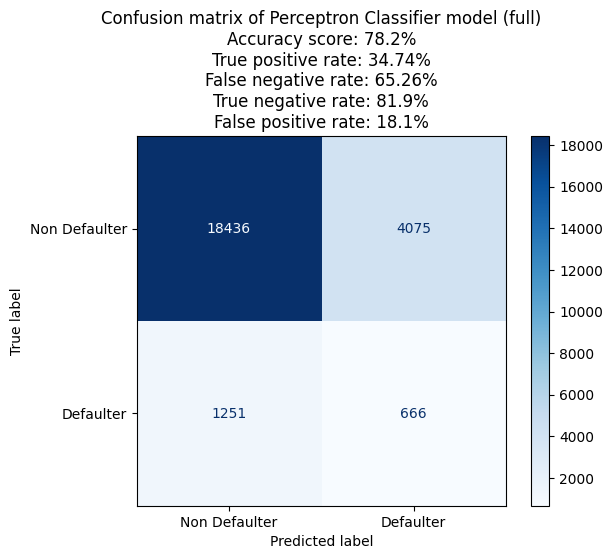

In [485]:
plot_cm(trained_model_full, x_test_full, y_test_full)

As seen above, the true positive rate is very low. That is, the accuracy of the model in predicting a defaulter is very low. This is likely due to an under-representation of defaulters in the dataset (there is not enough data on defaulters to accurately predict a defaulter). Hence, let's try using a dataset that has an equal ratio of defaulters and non defaulters and see if this can potentially improve the true positive rate.

In [486]:
# create a subset of data so that defaulters and non-defaulters are 1:1
defaulters = data.loc[data['TARGET'] == 1]
non_defaulters = data.loc[data['TARGET'] == 0]
non_defaulters_subset = non_defaulters.sample(len(defaulters))
subset_shuffled = pd.concat([non_defaulters_subset, defaulters])
subset_shuffled.reset_index(drop=True, inplace=True)
subset_shuffled

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,HOUR_APPR_PROCESS_START,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,0,0.052632,0.000931,0.152637,0.141377,0.733067,0.040198,0.796044,0.915659,0.739130,...,0,0,0,0,0,0,0,0,0,0
1,0,0.000000,0.002470,0.158249,0.256321,0.629444,0.044345,0.926637,0.908156,0.304348,...,0,0,0,0,0,0,0,0,0,0
2,0,0.000000,0.000739,0.049383,0.491595,0.209586,1.000000,0.419544,0.322912,0.391304,...,0,0,0,0,0,0,0,0,0,0
3,0,0.000000,0.001123,0.074074,0.392880,0.462653,0.037123,0.838197,0.909962,0.695652,...,0,0,0,0,0,0,0,0,0,0
4,0,0.052632,0.002085,0.176207,0.248124,0.576491,0.046201,0.639754,0.297902,0.434783,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38059,1,0.052632,0.001546,0.102132,0.276330,0.872068,0.038794,0.655196,0.641517,0.695652,...,0,0,0,0,0,0,0,0,0,0
38060,1,0.052632,0.001008,0.270483,0.097483,0.672468,0.040472,0.979734,0.346394,0.565217,...,0,0,0,0,0,0,0,0,0,0
38061,1,0.000000,0.001700,0.063973,0.114722,0.260029,0.038535,0.638416,0.467556,0.652174,...,0,0,0,0,0,0,0,0,0,0
38062,1,0.000000,0.001700,0.102132,0.196267,0.498146,0.046002,0.663951,0.998749,0.217391,...,0,0,0,0,0,0,0,0,0,0


In [487]:
# Split the data into 80% training set, 10% test set and 10% validation set
(x_train_subset, x_test_subset, x_validation_subset,
 y_train_subset, y_test_subset, y_validation_subset) = split_data(subset_shuffled)

print(x_train_subset.shape, x_test_subset.shape, x_validation_subset.shape, 
      y_train_subset.shape, y_test_subset.shape, y_validation_subset.shape)

(30451, 156) (3807, 156) (3806, 156) (30451,) (3807,) (3806,)


In [488]:
# load subset trained model if exists, else train new perceptrion classifier model
subset_model_file_name = 'perceptron_predictor_undersample.sav'
path = os.path.join(os.getcwd(), subset_model_file_name)
trained_model_subset = None
if os.path.exists(path):
    trained_model_subset = load_model(subset_model_file_name)
else:
    trained_model_subset = train_perceptron_model(x_train_subset, x_validation_subset,
                                                  y_train_subset, y_validation_subset)
    save_model(trained_model_subset, subset_model_file_name)

-- Epoch 1
Norm: 10.98, NNZs: 130, Bias: 0.000000, T: 30451, Avg. loss: 1.036028
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 11.76, NNZs: 131, Bias: 0.000000, T: 60902, Avg. loss: 1.024940
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 12.28, NNZs: 127, Bias: 0.750000, T: 91353, Avg. loss: 1.018213
Total training time: 0.03 seconds.
-- Epoch 4
Norm: 12.62, NNZs: 135, Bias: 0.250000, T: 121804, Avg. loss: 1.019635
Total training time: 0.05 seconds.
-- Epoch 5
Norm: 13.90, NNZs: 138, Bias: 0.500000, T: 152255, Avg. loss: 1.026228
Total training time: 0.06 seconds.
-- Epoch 6
Norm: 13.97, NNZs: 137, Bias: 0.500000, T: 182706, Avg. loss: 1.024247
Total training time: 0.07 seconds.
-- Epoch 7
Norm: 15.48, NNZs: 139, Bias: 0.250000, T: 213157, Avg. loss: 1.025863
Total training time: 0.08 seconds.
-- Epoch 8
Norm: 15.68, NNZs: 141, Bias: 0.500000, T: 243608, Avg. loss: 1.015994
Total training time: 0.09 seconds.
-- Epoch 9
Norm: 15.71, NNZs: 144, Bias: -0.250000, T: 274059, Avg.

In [489]:
# Show model and model accuracy
print("Trained Model Subset:", trained_model_subset)
print("Accuracy, TN rate:", custom_score(trained_model_subset, x_test_full, y_test_full))

Trained Model Subset: Perceptron(alpha=1, eta0=0.25, l1_ratio=0.1, n_jobs=-1, verbose=1)
Accuracy, TN rate: (0.5006140494514492, 0.7339593114241002)


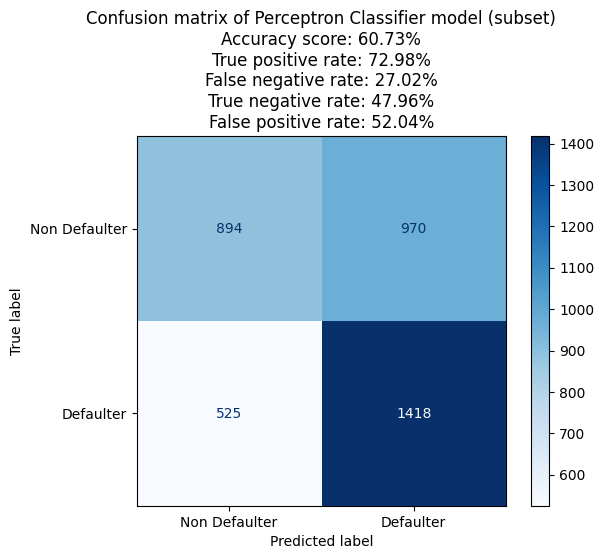

In [490]:
plot_cm(trained_model_subset, x_test_subset, y_test_subset, data_used="subset")

As seen from the results above, the true positive rate drastically improved from `0.27%` to `67.32%`. However, we also see a decrease in true negative rate from `99.98%` to `70.44%` and a drop in accuracy from `92.35%` to `68.85%`. Accuracy and true negative rate are now lower because the dataset used to train this model contains a lot less data on non defaulters compared to the one used to train the previous model. Nevertheless, this model can still predict, with reasonable accuracy (around 70% true negative and true positive rate), if someone is likely to be a defaulter or not. Hence, this model may be more useful than the previous one since the previous model is only very good at predicting non defaulters but not defaulters.

Alternatively, we now try to oversample the defaulters in the original dataset instead

In [491]:
# oversample data so that defaulters and non-defaulters are 1:1
defaulters = data.loc[data['TARGET'] == 1]
non_defaulters = data.loc[data['TARGET'] == 0]

defaulters_oversampled = defaulters.sample(len(non_defaulters), replace=True)
oversample_shuffled = pd.concat([defaulters_oversampled, non_defaulters])
oversample_shuffled.reset_index(drop=True, inplace=True)
oversample_shuffled

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,HOUR_APPR_PROCESS_START,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,1,0.000000,0.000854,0.046016,0.361433,0.838516,0.045425,0.814648,0.559817,0.739130,...,0,0,0,0,0,0,0,0,0,0
1,1,0.000000,0.003239,0.046016,0.392880,0.244165,1.000000,0.507498,0.455884,0.434783,...,0,0,0,0,0,0,0,0,0,0
2,1,0.000000,0.001123,0.158249,0.048783,0.567475,0.040936,0.999959,0.479505,0.260870,...,0,0,0,0,0,0,0,0,0,0
3,1,0.052632,0.000835,0.158249,0.344429,0.236862,1.000000,0.525413,0.390579,0.347826,...,0,0,0,0,0,0,0,0,0,0
4,1,0.000000,0.001239,0.034792,0.257000,0.485592,0.033556,0.693377,0.968181,0.782609,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450491,0,0.052632,0.000585,0.046016,0.147830,0.521427,0.023949,0.648508,0.370432,0.695652,...,0,0,0,0,0,0,0,0,0,0
450492,0,0.000000,0.000739,0.051627,0.311695,0.760685,0.045707,0.972641,0.453105,0.478261,...,0,0,0,0,0,0,0,0,0,0
450493,0,0.000000,0.000739,0.046016,0.311695,0.046619,1.000000,0.701321,0.672502,0.652174,...,0,0,0,0,0,0,0,0,0,0
450494,0,0.000000,0.001085,0.135802,0.065247,0.584023,0.026076,0.726937,0.284424,0.391304,...,0,0,0,0,0,0,0,0,0,0


In [492]:
# Split the data into 80% training set, 10% test set and 10% validation set
(x_train_oversampled, x_test_oversampled, x_validation_oversampled,
 y_train_oversampled, y_test_oversampled, y_validation_oversampled) = split_data(oversample_shuffled)

print(x_train_oversampled.shape, x_test_oversampled.shape, x_validation_oversampled.shape, 
      y_train_oversampled.shape, y_test_oversampled.shape, y_validation_oversampled.shape)

(360396, 156) (45050, 156) (45050, 156) (360396,) (45050,) (45050,)


In [493]:
# load oversampled trained model if exists, else train new perceptron classifier
oversample_model_file_name = 'perceptron_predictor_oversample.sav'
path = os.path.join(os.getcwd(), oversample_model_file_name)
trained_model_oversample = None
if os.path.exists(path):
    trained_model_oversample = load_model(oversample_model_file_name)
else:
    trained_model_oversample = train_perceptron_model(x_train_oversampled, x_validation_oversampled,
                                                  y_train_oversampled, y_validation_oversampled)
    save_model(trained_model_oversample, oversample_model_file_name)

-- Epoch 1
Norm: 16.83, NNZs: 140, Bias: -0.500000, T: 360396, Avg. loss: 1.024381
Total training time: 0.17 seconds.
-- Epoch 2
Norm: 21.04, NNZs: 140, Bias: -0.750000, T: 720792, Avg. loss: 1.019884
Total training time: 0.35 seconds.
-- Epoch 3
Norm: 25.77, NNZs: 143, Bias: -1.000000, T: 1081188, Avg. loss: 1.022929
Total training time: 0.52 seconds.
-- Epoch 4
Norm: 29.44, NNZs: 144, Bias: -1.000000, T: 1441584, Avg. loss: 1.021122
Total training time: 0.69 seconds.
-- Epoch 5
Norm: 33.06, NNZs: 139, Bias: -0.500000, T: 1801980, Avg. loss: 1.021121
Total training time: 0.86 seconds.
-- Epoch 6
Norm: 37.17, NNZs: 144, Bias: -1.500000, T: 2162376, Avg. loss: 1.022395
Total training time: 1.03 seconds.
-- Epoch 7
Norm: 40.06, NNZs: 139, Bias: -1.000000, T: 2522772, Avg. loss: 1.021531
Total training time: 1.20 seconds.
Convergence after 7 epochs took 1.20 seconds
-- Epoch 1
Norm: 33.67, NNZs: 140, Bias: -1.000000, T: 360396, Avg. loss: 2.048762
Total training time: 0.21 seconds.
-- Epo

In [494]:
# Show model and model accuracy
print("Trained Model Oversample:", trained_model_oversample)
print("Accuracy, TN rate:", custom_score(trained_model_oversample, x_test_oversampled, y_test_oversampled))

Trained Model Oversample: Perceptron(alpha=1, eta0=0.25, l1_ratio=0.1, n_jobs=-1, verbose=1)
Accuracy, TN rate: (0.6413762486126526, 0.5728627659103976)


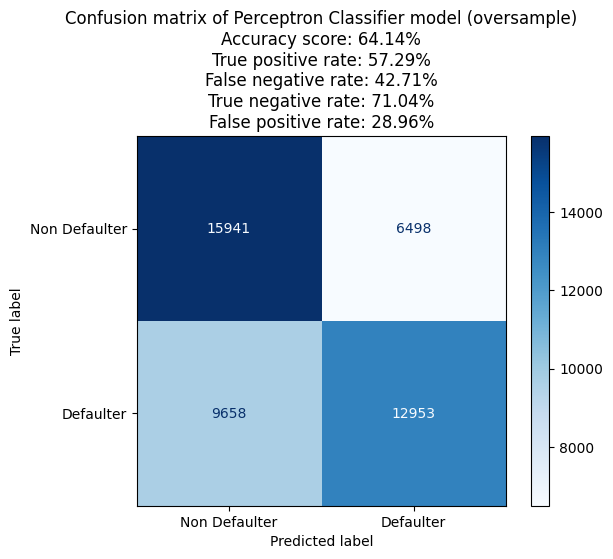

In [495]:
plot_cm(trained_model_oversample, x_test_oversampled, y_test_oversampled, data_used="oversample")